In [1]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

import pennylane as qml

In [2]:
data = {}

dpath = r'C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\Files\DW\DW_16.json'
with open(dpath, 'r') as json_file:
    data = json.load(json_file)

In [3]:
data_dict = {}

cutoff = data['cutoff']
potential = data['potential']

print(f"Finding optimal circuit for {potential} - cutoff {cutoff}")

num_qubits = int(np.log2(cutoff)) + 1
min_eigenvalue = min(data['exact_eigenvalues'])

# Only consider data that has converge to min energy
mask = []
for d in data['min_energies']:
    if abs(d - min_eigenvalue) < 1e-6:
        mask.append(True)
    else:
        mask.append(False)

# Clean and prepare circuit data
d_ops = [op.replace('))',')') for op in data['op_list']]
min_ops = [op_list for op_list, keep in zip(d_ops, mask) if keep]
min_ops = [eval(ops, {"RY": qml.RY, "CRX": qml.CRX, "CRY": qml.CRY, "np": np}) for ops in min_ops]
energies = [op_list for op_list, keep in zip(data['all_energies'], mask) if keep]

# Find op list with minimum number of gates
min_len = min([len(ops) for ops in min_ops])
reduced = [ops for ops in min_ops if len(ops) == min_len]

# Take the unique circuits
unique = []
for op_list in reduced:
    if op_list not in unique:
        unique.append(op_list)


basis_state = data['basis_state']

data_dict['potential'] = potential
data_dict['cutoff'] = cutoff
data_dict['basis_state'] = basis_state
data_dict['circuits'] = unique



Finding optimal circuit for DW - cutoff 16


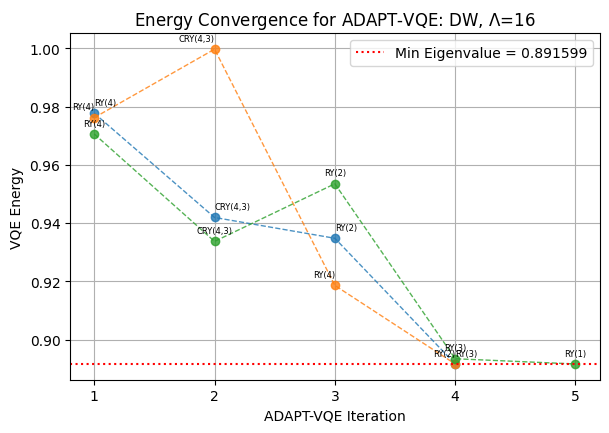

In [6]:
plt.figure(figsize=(6,4))

for i, position in zip([1, 33,-1],['left','right','center']):

    ops = min_ops[i]
    op_labels = []

    for op in ops:
        
        wires = op.wires
        if len(wires) > 1:
            label = f'CRY({str(wires[0])},{str(wires[1])})'
        else:
            label = f"{op.label()}({str(wires[0])})"

        op_labels.append(label)


    energy_list = energies[i]

    plt.plot(range(1, len(energy_list) + 1), energy_list, marker='o', linestyle='--', alpha=0.8, linewidth=1)
    

    for i, op in enumerate(op_labels):
        plt.annotate(op, (i + 1, energy_list[i]), textcoords="offset points", xytext=(0,6), ha=position, fontsize=6, color='black')

    plt.tight_layout()
    
plt.axhline(y=min_eigenvalue, color='red', linestyle=':', label=f'Min Eigenvalue = {min_eigenvalue:.6f}')
plt.xlabel('ADAPT-VQE Iteration')
plt.xticks(range(1, len(energy_list)  + 1))
plt.ylabel('VQE Energy')
plt.title(f"Energy Convergence for ADAPT-VQE: {potential}, $\\Lambda$={cutoff}")
plt.grid(True)
plt.legend()
plt.show()
